In [22]:
import numpy as np
import pims
from pims.bioformats import BioformatsReader
import skimage as ski
import skimage.transform as skitransform
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn import linear_model
import sklearn
import register_stack_correlation_lib as reglib
from tifffile import TiffWriter
import os

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Load image reader
data_path = ('/Users/andrewkennard/Desktop/')
image_source = os.path.join(data_path,
                '20180502_63x_2xopt_Wounding_2_Subimage_downsampled.tif')
images = BioformatsReader(image_source)
images.bundle_axes = 'zyx'
images.iter_axes = 't'

/Users/andrewkennard/.virtualenvs/myenv/lib/python3.6/site-packages/pims/bioformats.py:386: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [3]:
# Set two example images (zyx stacks) and downsample
downscale_factor = 4
im0 = images[10]
im1 = images[11]
im0_downscaled = reglib.downscale_frame(im0,downscale_factor)
im1_downscaled = reglib.downscale_frame(im1,downscale_factor)

Time elapsed: 		 8.01680183201097
Fitted intercept: 	 -6.9090909090909065


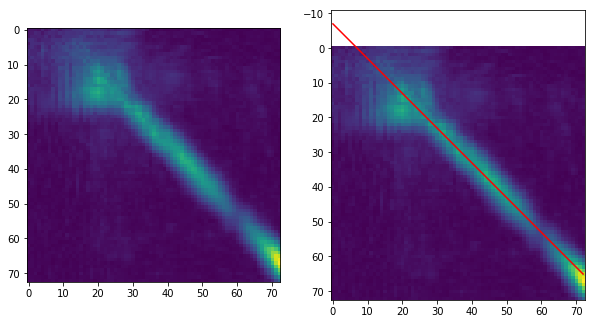

In [4]:
# Compute phase correlation and the correct fitted intercept for the correlation
t0 = time.perf_counter()
max_correlation = reglib.compute_phase_corr_stacks(im0_downscaled,im1_downscaled)
t1 = time.perf_counter()
print("Time elapsed: \t\t", t1-t0)
fig,ax = plt.subplots(figsize=(10,20),ncols=2)
ax[0].imshow(max_correlation)
ax[1].imshow(max_correlation)
intercept = reglib.fit_intercept_ransac(max_correlation)
X = np.arange(max_correlation.shape[0])
ax[1].plot(X,X+intercept,c='r')
print("Fitted intercept: \t", intercept)

In [31]:
# Convert the intercept into a registration to save; for now just round to the nearest whole frame
# intercept -k --> cut off the first k frames from im1 and append k blank frames at the end of im1
# intercept +k --> append k blank frames to the front of im1 and cut off the last k frames
frame_difference = int(round(intercept))
im1_reg = np.zeros_like(im1)
if frame_difference < 0:
    im1_reg[:frame_difference, ...] = im1[(-frame_difference):, ...]
elif frame_difference > 0:
    im1_reg[frame_difference:, ...] = im1[:(-frame_difference), ...]
else:
    im1_reg = im1;
save_name = os.path.join(data_path,'testRegistration','im0_reg.tif')
with TiffWriter(save_name,imagej=True) as writer:
    writer.save(im0)
save_name = os.path.join(data_path,'testRegistration','im1_reg.tif')
with TiffWriter(save_name,imagej=True) as writer:
    writer.save(im1_reg)

In [29]:
int(round(-6.9))

-7

In [19]:
x = np.arange(10)
x[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])